In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim

torch.set_default_dtype(torch.float64)

In [2]:
df = pd.read_csv("./data_synthetic/synth_data_1var_poi.csv", index_col=0)
df

,X,y
0,1,0.002686
1,1,0.002753
2,1,0.003596
3,1,0.003369
4,1,0.002748
...,...,...
145,18,0.000241
146,18,0.000385
147,18,0.000939
148,18,0.000155


In [3]:
X = torch.tensor(df["X"]).reshape(-1, 1)
y = torch.tensor(df["y"]).reshape(-1, 1)

In [4]:
class NN(nn.Module):

    def __init__(self):
        super(NN, self).__init__()
        self.hidden = nn.Linear(1, 25)
        self.swish = lambda x: x * torch.sigmoid(x)
        self.output = nn.Linear(25, 1)
    
    def forward(self, x):
        x = self.hidden(x)
        x = self.swish(x)
        x = self.output(x)
        return x

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train = torch.tensor(X_train, dtype=torch.float64).reshape(-1,1)
y_train = torch.tensor(y_train, dtype=torch.float64).reshape(-1,1)

C:\Users\kyle\AppData\Local\Temp\ipykernel_20300\192023414.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float64).reshape(-1,1)
C:\Users\kyle\AppData\Local\Temp\ipykernel_20300\192023414.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float64).reshape(-1,1)


In [6]:
model = NN()
model.load_state_dict(torch.load('nn_model_1Var_poi_SWISH.pt', weights_only=True))

y_pred_NN = model(torch.tensor(X, dtype=torch.float64))

C:\Users\kyle\AppData\Local\Temp\ipykernel_20300\3532894761.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_NN = model(torch.tensor(X, dtype=torch.float64))


In [7]:
h = np.vectorize(lambda x : np.log(x)) # modify h as needed
h_inv = np.vectorize(lambda x : np.exp(x))

regr = LinearRegression()
regr.fit(X_train, h(y_train))

y_pred_GLM = h_inv(regr.predict(X))

In [8]:
# sorted_indices = torch.argsort(X_test, dim=0).squeeze()
# X_test = X_test[sorted_indices]
# y_pred_NN = y_pred_NN[sorted_indices]
# y_pred_GLM = y_pred_GLM[sorted_indices]

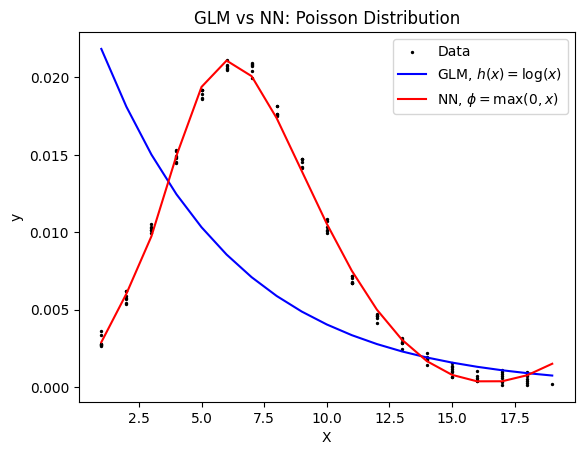

In [9]:
import matplotlib.pyplot as plt

plt.scatter(X_train, y_train, color="black",s=2, label='Data')
plt.plot(X, y_pred_GLM, color='blue', label=r'GLM, $h(x) = \log(x)$')
plt.plot(X, y_pred_NN.detach(), color="red", label=r'NN, $\phi = \max(0,x)$')

plt.xlabel("X")
plt.ylabel("y")
plt.title(r"GLM vs NN: Poisson Distribution")
plt.legend()
plt.savefig(f"img/GLM-NN_1Var_poi_swish.png")
plt.show()